# Mood GLM Results 
*Updated: 11/20/2024*

In [1]:
import numpy as np
import pandas as pd
from glob import glob
# from numpy.linalg import vecdot
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr, norm 
import scipy.stats as stats
from scipy.optimize import least_squares, minimize
from sklearn.metrics import r2_score
import random
import os
# from statannot import add_stat_annotation
from statsmodels.stats.outliers_influence import variance_inflation_factor
import itertools
import datetime
import statsmodels.api as sm
from joblib import Parallel, delayed
from tqdm import tqdm
import pickle



In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
base_dir  = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/'
paper_dir = f'{base_dir}manuscript/'
behav_dir = f'{paper_dir}data/behav/'
fig_dir   = f'{paper_dir}figs/behav/'
os.makedirs(fig_dir,exist_ok=True)

date = datetime.date.today().strftime('%m%d%Y')
print(date)


11212024


In [4]:
# import sys
# sys.path.append(f'{base_dir}swb_computational_modeling/swb_behav_models/scripts')
# from SWB_modeling_utils import *

import sys
sys.path.append(f'{paper_dir}scripts/behav/')
from behav_utils import *
from swb_subj_behav import *


In [5]:
date = datetime.date.today().strftime('%m%d%Y')
print(date)

11212024


In [6]:
# load subj_ids of subj with preprocessed ephys data
subj_ids = pd.read_excel(f'{base_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID.tolist()
# find subj without sufficient variation in mood ratings and drop from subj_ids list 
# subj_ids = [subj_ids[idx] for idx in np.arange(0,len(subj_ids))[pd.read_excel(f'{base_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[2]).mood_var.isnull()]]
bad_subj = ['MS028','MS050']
subj_ids = [s for s in subj_ids if s not in bad_subj]
subj_ids


['MS002',
 'MS003',
 'MS009',
 'MS011',
 'MS015',
 'MS016',
 'MS017',
 'MS019',
 'MS022',
 'MS024',
 'MS025',
 'MS026',
 'MS027',
 'MS029',
 'MS030',
 'MS033',
 'MS035',
 'MS041',
 'MS043',
 'MS048',
 'DA8',
 'DA023',
 'DA026',
 'DA037',
 'DA039']

In [7]:
# mood_behav_data = pd.read_csv(f'{paper_dir}data/behav/all_behav_clean_08292024.csv')
mood_behav_data = pd.read_csv(f'{paper_dir}data/mood/mood_model_data.csv')
mood_behav_data = mood_behav_data[~mood_behav_data.subj_id.isin(bad_subj)]
mood_behav_data

,Unnamed: 0,subj_id,bdi,bdi_thresh,Round,Rating,RatingOnset,RT,Round_t1_idx,Round_t2_idx,...,rpe_t3,cf_t1,cf_t2,cf_t3,cpe_t1,cpe_t2,cpe_t3,mood_epoch_len,next_round_start,norm_mood
0,0,MS002,14,low,4,70.0,539.343131,5.210698,3,2,...,-0.017374,0.551367,-0.307083,0.759848,1.461373,-0.892581,-0.795008,5.310698,545.592613,0.277664
1,1,MS002,14,low,7,70.0,572.673634,3.332630,6,5,...,-0.017374,-1.288170,0.674003,-0.920262,1.241834,0.802754,0.875934,3.432630,577.049490,0.277664
2,2,MS002,14,low,10,69.0,605.109393,3.499831,9,8,...,-1.720166,0.060824,-0.307083,-0.674991,-1.441430,0.266101,-1.185300,3.599831,609.642231,0.134538
3,3,MS002,14,low,13,71.0,638.791836,3.884104,12,11,...,-1.103047,1.164546,0.306096,0.428731,-1.197497,0.680788,-0.465698,3.984104,643.713750,0.420789
4,4,MS002,14,low,16,71.0,671.977904,4.250371,15,14,...,-0.017374,0.060824,0.796639,0.060824,1.729700,-0.831598,-0.831598,4.350371,677.264040,0.420789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058,1058,DA039,22,high,130,62.0,2068.532096,3.829234,129,128,...,0.046736,0.915739,0.605708,-0.882439,0.676475,-0.531355,0.386596,3.929234,2073.394432,0.928652
1059,1059,DA039,22,high,136,45.0,2141.050732,2.415390,135,134,...,0.046736,-0.014353,-0.014353,-0.014353,-1.014487,-0.289789,-0.772921,2.515390,2144.478929,-0.524890
1060,1060,DA039,22,high,142,45.0,2211.211948,2.961470,141,140,...,0.046736,0.760724,-3.362685,-0.014353,-0.652138,1.835992,-0.289789,3.061470,2215.197736,-0.524890
1061,1061,DA039,22,high,148,68.0,2276.912826,4.403968,147,146,...,-1.152672,-2.339584,0.605708,0.760724,1.763523,1.497800,-0.652138,4.503968,2282.349445,1.441667


# Format model results

In [8]:
# model_results= pickle.load(open(f'{paper_dir}mood_model_results_dict.pkl','rb'))
# model_results= pickle.load(open(f'{paper_dir}data/mood/mood_model_results_dict_10042024.pkl','rb'))
model_results= pickle.load(open(f'{paper_dir}data/mood/mood_model_results_dict_{date}.pkl','rb'))
# f'{paper_dir}data/mood/mood_model_results_dict_{date}.pkl'


In [9]:
model_results.keys()

dict_keys(['GambleEV_cpe', 'TrialEV_cpe', 'TotalProfit_cpe', 'rpe_cpe', 'Profit_cpe', 'GambleEV_TotalProfit_cpe', 'GambleEV_rpe_cpe', 'GambleEV_Profit_cpe', 'TrialEV_TotalProfit_cpe', 'TrialEV_rpe_cpe', 'TrialEV_Profit_cpe', 'TotalProfit_rpe_cpe', 'TotalProfit_Profit_cpe', 'rpe_Profit_cpe', 'GambleEV_TotalProfit_rpe_cpe', 'GambleEV_TotalProfit_Profit_cpe', 'GambleEV_rpe_Profit_cpe', 'TrialEV_TotalProfit_rpe_cpe', 'TrialEV_TotalProfit_Profit_cpe', 'TrialEV_rpe_Profit_cpe', 'TotalProfit_rpe_Profit_cpe', 'GambleEV_TotalProfit_rpe_Profit_cpe', 'TrialEV_TotalProfit_rpe_Profit_cpe'])

In [12]:
# all_subj_model_data[subj_id]['best_result'].success

In [10]:
model_list        = list(model_results.keys())
model_inputs      = {}
all_models_output = {}
all_models_mood   = {}

for model_id in model_list:
    all_subj_model_data    = model_results[model_id]
    model_vars             = all_subj_model_data['MS002']['subj_dict']['reg_list']
    model_inputs[model_id] = model_vars
    param_est_cols = ['gamma','b0'] + ['_'.join(['b1',reg]) for reg in list(set([reg.split('_')[0] for reg in model_vars]))]

    model_output_df = []
    mood_fit_df     = {}

    for subj_id in subj_ids:
        # check for model convergence
        # conv_check = all_subj_model_data[subj_id]['best_result'].success
        if all_subj_model_data[subj_id]['best_result'].success:
            # save model mood prediction 
            mood_fit_df[subj_id] = all_subj_model_data[subj_id]['subj_dict']['pred_mood']
            # create output dict with columns for each param estimate
            subj_param_fits = {f'{p}':float(all_subj_model_data[subj_id]['subj_dict']['params'][ix]) for ix,p in enumerate(param_est_cols)}
            # add subj info to dict 
            subj_param_fits['model_id'] = model_id
            subj_param_fits['subj_id']  = subj_id
            subj_param_fits['bdi']      = mood_behav_data[mood_behav_data.subj_id==subj_id].bdi.unique()[0]
            subj_param_fits['bic']      = float(all_subj_model_data[subj_id]['subj_dict']['bic'])
            subj_param_fits['negll']    = float(all_subj_model_data[subj_id]['subj_dict']['negll'])
            # save info into df 
            model_output_df.append(pd.DataFrame(subj_param_fits,index=[0])[['subj_id','bdi','model_id','bic','negll']+param_est_cols])
        else:
            print(f'{model_id} for {subj_id} did not converge')
            # only save model data for models that converged
            continue
    # save all subj data
    all_models_output[model_id] = pd.concat(model_output_df).reset_index(drop=True)
    # all_models_mood[model_id]   = pd.DataFrame(mood_fit_df)


In [11]:
[mood_fit_df[key].shape for key in list(mood_fit_df.keys())]

[(48,),
 (45,),
 (49,),
 (44,),
 (32,),
 (38,),
 (49,),
 (39,),
 (42,),
 (11,),
 (49,),
 (45,),
 (47,),
 (45,),
 (49,),
 (46,),
 (46,),
 (48,),
 (49,),
 (48,),
 (49,),
 (40,),
 (40,),
 (42,),
 (23,)]

In [29]:
mood_behav_data.columns

Index(['Unnamed: 0', 'subj_id', 'bdi', 'bdi_thresh', 'Round', 'Rating',
       'RatingOnset', 'RT', 'Round_t1_idx', 'Round_t2_idx', 'Round_t3_idx',
       'epoch', 'epoch_t1_idx', 'epoch_t2_idx', 'epoch_t3_idx', 'keep_mood',
       'logRT', 'MoodChoiceOnset', 'SafeBet_t1', 'SafeBet_t2', 'SafeBet_t3',
       'LowBet_t1', 'LowBet_t2', 'LowBet_t3', 'HighBet_t1', 'HighBet_t2',
       'HighBet_t3', 'Profit_t1', 'Profit_t2', 'Profit_t3', 'TotalProfit_t1',
       'TotalProfit_t2', 'TotalProfit_t3', 'GambleEV_t1', 'GambleEV_t2',
       'GambleEV_t3', 'TrialEV_t1', 'TrialEV_t2', 'TrialEV_t3', 'CR_t1',
       'CR_t2', 'CR_t3', 'choiceEV_t1', 'choiceEV_t2', 'choiceEV_t3', 'rpe_t1',
       'rpe_t2', 'rpe_t3', 'cf_t1', 'cf_t2', 'cf_t3', 'cpe_t1', 'cpe_t2',
       'cpe_t3', 'mood_epoch_len', 'next_round_start', 'norm_mood'],
      dtype='object')

In [15]:
### model with overall lowest bic 

In [30]:
all_models_output[model_id]

,subj_id,bdi,model_id,bic,negll,gamma,b0,b1_rpe,b1_Profit,b1_TrialEV,b1_TotalProfit,b1_cpe
0,MS002,14,TrialEV_TotalProfit_rpe_Profit_cpe,154.246987,63.574290,0.690557,0.015080,0.015242,0.057350,-0.038329,0.365170,0.050070
1,MS003,8,TrialEV_TotalProfit_rpe_Profit_cpe,137.299885,55.326624,0.000010,0.054035,1.249522,-0.090873,1.398089,-1.804692,0.546882
2,MS009,16,TrialEV_TotalProfit_rpe_Profit_cpe,149.304975,61.031117,0.042945,-0.033741,-1.533476,-0.506291,-0.984602,1.851382,-0.389518
3,MS011,13,TrialEV_TotalProfit_rpe_Profit_cpe,143.775361,58.643017,0.196458,0.073566,0.337120,0.089343,0.444447,-0.162289,0.134554
4,MS015,26,TrialEV_TotalProfit_rpe_Profit_cpe,107.398577,41.569213,1.000000,-0.007726,-0.841804,-0.184747,-0.825026,1.316930,-0.076527
5,MS016,10,TrialEV_TotalProfit_rpe_Profit_cpe,99.847045,37.191971,0.568225,0.116462,0.084149,-0.046188,0.366801,-0.124770,0.204986
6,MS017,26,TrialEV_TotalProfit_rpe_Profit_cpe,144.541489,58.649374,0.683268,0.069783,0.258378,-0.000338,0.266239,-0.156761,0.344119
7,MS019,12,TrialEV_TotalProfit_rpe_Profit_cpe,120.837258,47.596163,0.293313,0.061289,0.274382,0.332599,0.345270,-0.078391,0.056537
8,MS022,10,TrialEV_TotalProfit_rpe_Profit_cpe,120.548010,47.192162,0.083196,-0.005207,0.901869,0.487282,1.408179,-1.103939,-0.119393
9,MS024,16,TrialEV_TotalProfit_rpe_Profit_cpe,29.335411,6.275072,0.570661,0.918109,-1.005906,0.452981,-0.714786,1.154518,0.308836


# Interpret Model Results
**MS028, MS050 should be ignored!**

In [31]:
all_models_output

{'GambleEV_cpe':    subj_id  bdi      model_id         bic      negll     gamma        b0  \
 0    MS002   14  GambleEV_cpe  143.181472  63.848334  1.000000 -0.007257   
 1    MS003    8  GambleEV_cpe  129.706584  57.239967  0.000010  0.044914   
 2    MS009   16  GambleEV_cpe  154.181281  69.307000  1.000000  0.017742   
 3    MS011   13  GambleEV_cpe  136.589522  60.726382  0.011252  0.073545   
 4    MS015   26  GambleEV_cpe  106.901519  46.519288  0.949676  0.059182   
 5    MS016   10  GambleEV_cpe   94.114492  39.782074  0.501530  0.069680   
 6    MS017   26  GambleEV_cpe  134.613232  59.522975  0.680239  0.073427   
 7    MS019   12  GambleEV_cpe  118.670752  52.008253  0.384178  0.014798   
 8    MS022   10  GambleEV_cpe  125.472515  55.260918  0.882781  0.101674   
 9    MS024   16  GambleEV_cpe   42.115921  16.262170  1.000000 -0.627420   
 10   MS025   10  GambleEV_cpe  134.340030  59.386374  0.641187 -0.025295   
 11   MS026    9  GambleEV_cpe  139.771484  62.272417  0.000

In [32]:
model_bic_data = []
bic_means = []

for model_id in list(all_models_output.keys()):
    output_df = all_models_output[model_id]
    # output_df = output_df[output_df.subj_id.isin(subj_ids)]
    model_bic_data.append(output_df[['model_id','subj_id','bdi','bic','negll']])
    bic_means.append(pd.DataFrame({'model_id':model_id,'total_mean':float(np.mean(output_df.bic)),
                                   'low_bdi_mean':float(np.mean(output_df[output_df.bdi<20].bic)),
                                   'high_bdi_mean':float(np.mean(output_df[output_df.bdi>=20].bic))},index=[0]))
model_bic_data = pd.concat(model_bic_data).reset_index(drop=True)
bic_means = pd.concat(bic_means).reset_index(drop=True)

In [33]:
bic_means

,model_id,total_mean,low_bdi_mean,high_bdi_mean
0,GambleEV_cpe,124.240580,126.828367,117.586271
1,TrialEV_cpe,124.049190,126.673637,117.300612
2,TotalProfit_cpe,120.211677,121.977731,115.670395
3,rpe_cpe,125.255633,127.412936,119.708283
4,Profit_cpe,122.615038,125.324496,115.647860
5,GambleEV_TotalProfit_cpe,119.649937,122.368028,112.660559
6,GambleEV_rpe_cpe,125.160235,127.845003,118.256547
7,GambleEV_Profit_cpe,124.729328,127.624195,117.285383
8,TrialEV_TotalProfit_cpe,119.427427,122.172968,112.367464
9,TrialEV_rpe_cpe,124.882188,127.632313,117.810438


In [34]:
bic_means[bic_means.total_mean == np.min(bic_means.total_mean)].model_id.values[0]

'TotalProfit_Profit_cpe'

In [35]:
bic_means[bic_means.low_bdi_mean == np.min(bic_means.low_bdi_mean)].model_id.values[0]

'TotalProfit_Profit_cpe'

In [36]:
bic_means[bic_means.high_bdi_mean == np.min(bic_means.high_bdi_mean)].model_id.values[0]

'TotalProfit_Profit_cpe'

b1_cpe 0.0005921751805487585 0.903886602544643
model GambleEV_cpe bdi corr: 0.06131433121757037 0.7709364259291297


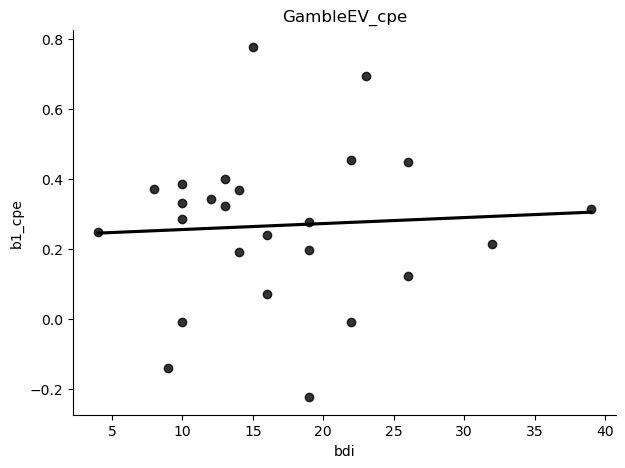

b1_cpe -0.002637279366559538 0.564780312107726
model TrialEV_cpe bdi corr: -0.17662232570021832 0.39835166412296485


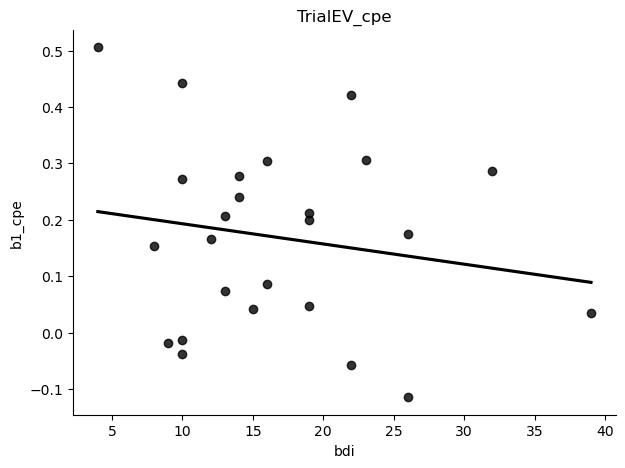

b1_cpe -0.002144928687201031 0.6744158717390956
model TotalProfit_cpe bdi corr: 0.022512408596677434 0.9149377436216936


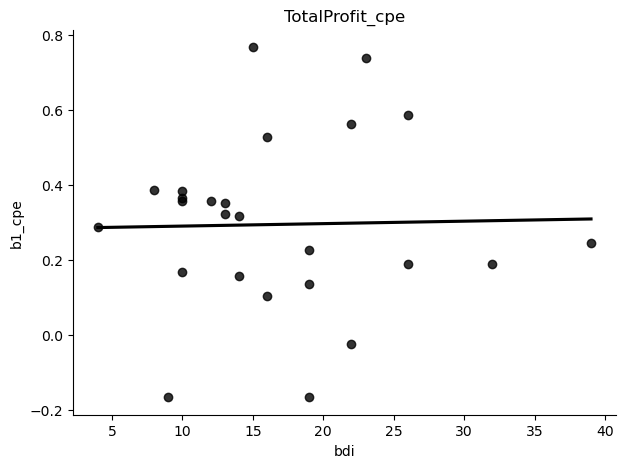

b1_cpe 0.00031707936650555323 0.9512702979766583
model rpe_cpe bdi corr: 0.055791955767733256 0.7910986728290453


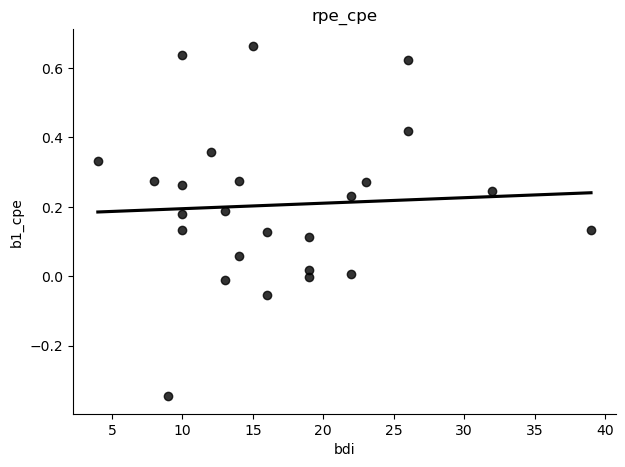

b1_cpe -0.005628418630464865 0.2760644700194037
model Profit_cpe bdi corr: -0.35011121917090005 0.08621324703154222


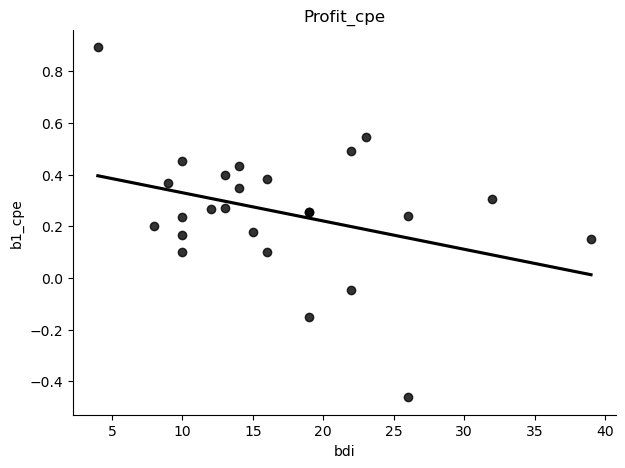

b1_cpe 9.667230152830921e-05 0.9862778734780357
model GambleEV_TotalProfit_cpe bdi corr: 0.0491021935223769 0.8156977427153819


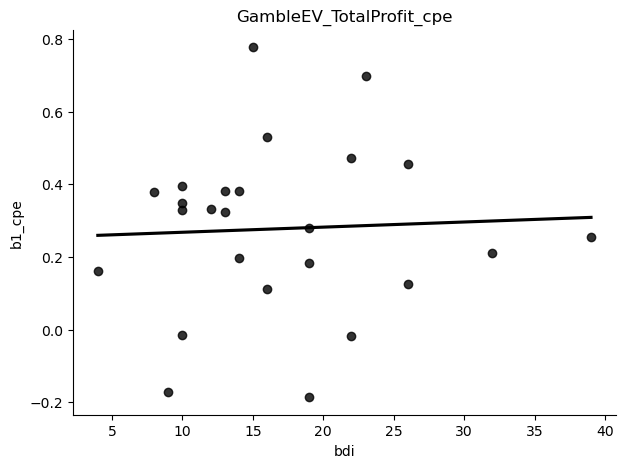

b1_cpe 0.004820280286549449 0.15375926390816347
model GambleEV_rpe_cpe bdi corr: 0.32210915469273566 0.1163504625580286


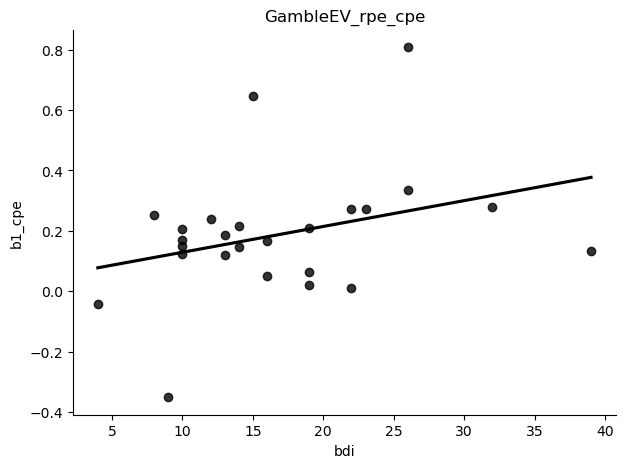

b1_cpe -0.0006258111277750348 0.9184092287965757
model GambleEV_Profit_cpe bdi corr: -0.030186407743191087 0.8861029141351667


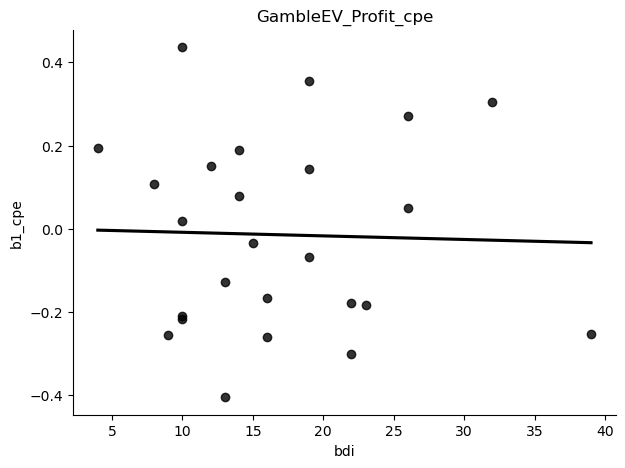

b1_cpe 0.001459214885691004 0.8069300024817799
model TrialEV_TotalProfit_cpe bdi corr: 0.037279405302623046 0.8595749432803209


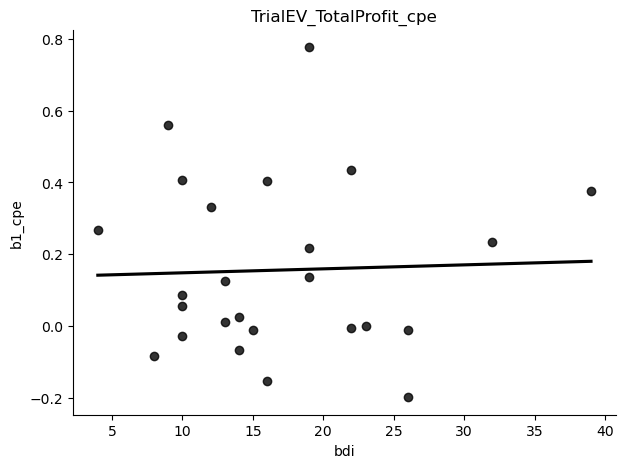

b1_cpe -0.005093473422971524 0.25530327778448547
model TrialEV_rpe_cpe bdi corr: -0.2627089389772183 0.20454014883415644


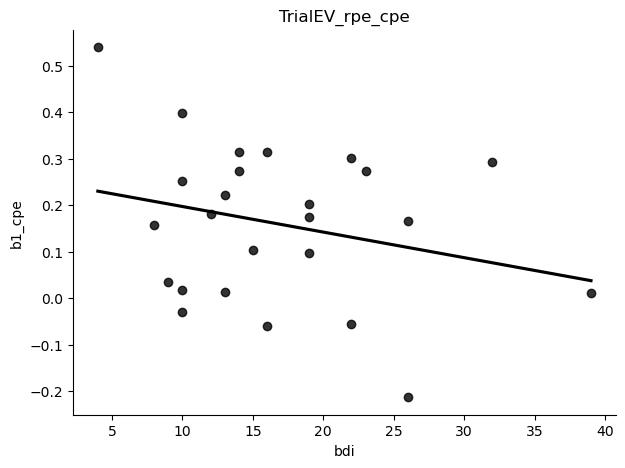

b1_cpe -0.001265863839689763 0.8725360509696829
model TrialEV_Profit_cpe bdi corr: -0.029441045457136144 0.8888980118802734


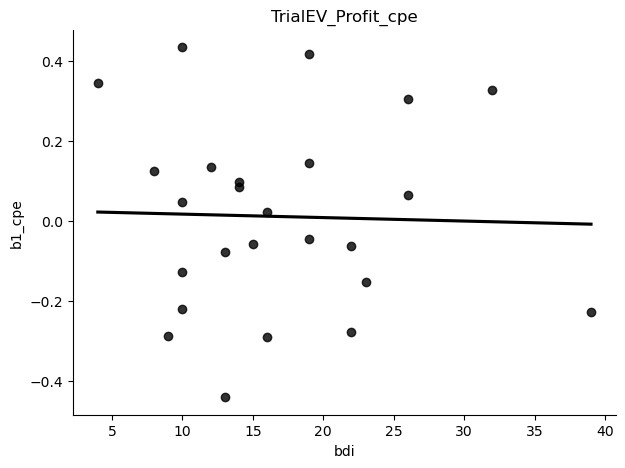

b1_cpe -7.101735923310202e-05 0.9902664819808263
model TotalProfit_rpe_cpe bdi corr: -0.014854715251519844 0.9438158428655624


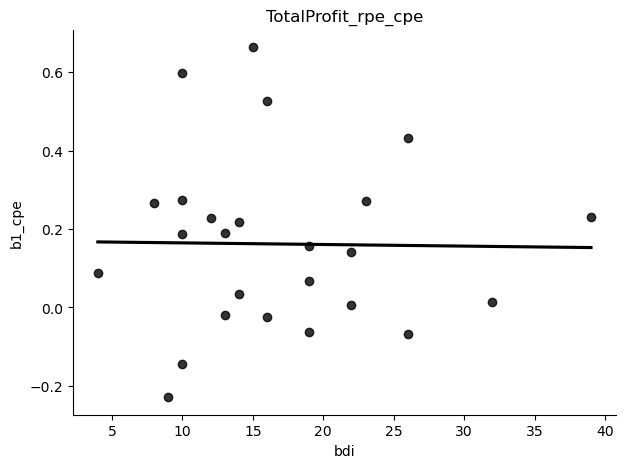

b1_cpe -0.009043393981458763 0.11640430128140848
model TotalProfit_Profit_cpe bdi corr: -0.3479531101738954 0.08830144087080401


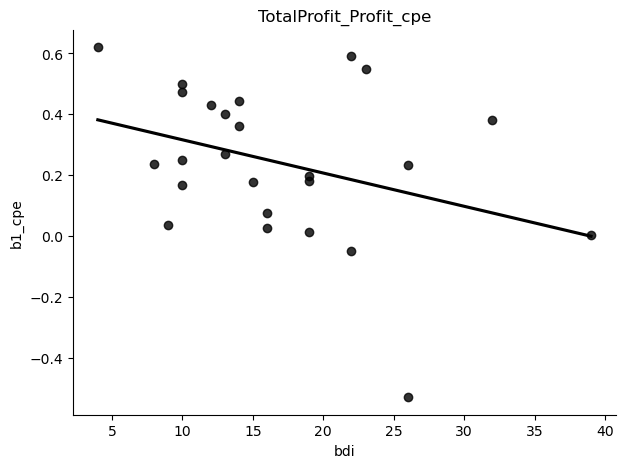

b1_cpe -0.004366364741705807 0.5011751586802606
model rpe_Profit_cpe bdi corr: -0.12773530100669622 0.542869419049997


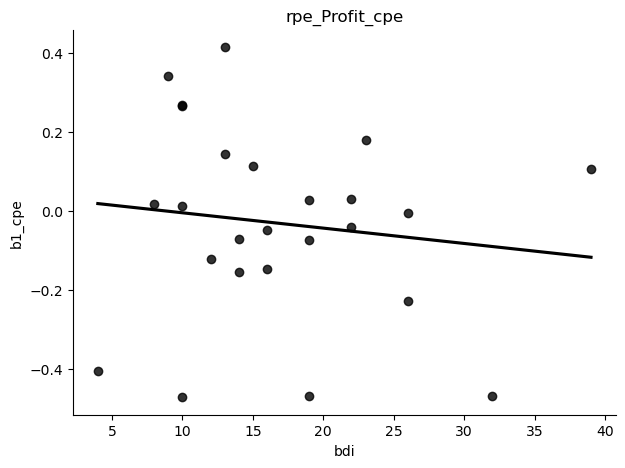

b1_cpe 0.006831187438166602 0.121908779098219
model GambleEV_TotalProfit_rpe_cpe bdi corr: 0.2955686865750707 0.15143998467152803


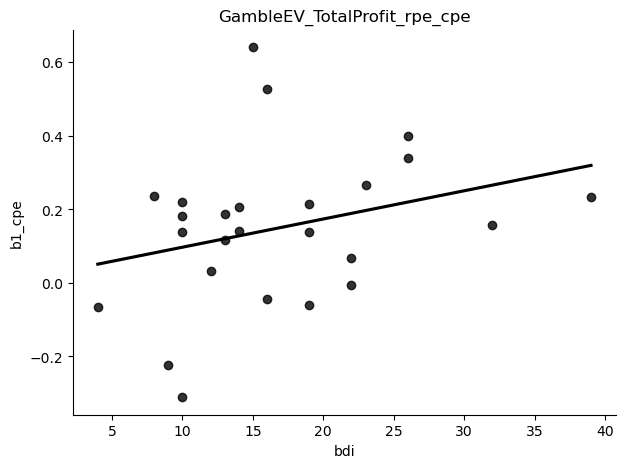

b1_cpe 0.0032255741797103227 0.5781878995948144
model GambleEV_TotalProfit_Profit_cpe bdi corr: 0.18492867654563347 0.37617106770066727


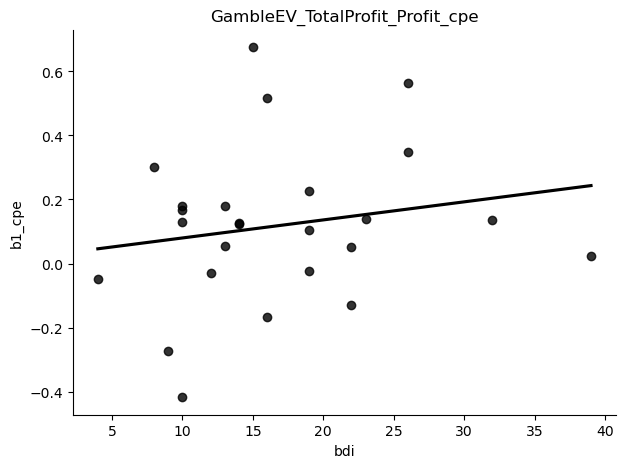

b1_cpe -0.020870145369869347 0.1410331378318843
model GambleEV_rpe_Profit_cpe bdi corr: -0.25710491217905085 0.2147178648461474


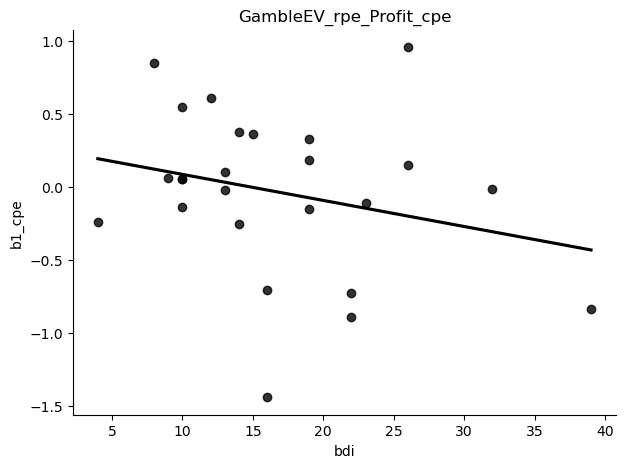

b1_cpe -0.007427773318788239 0.09689776348726162
model TrialEV_TotalProfit_rpe_cpe bdi corr: -0.28080510152360416 0.17392860366141513


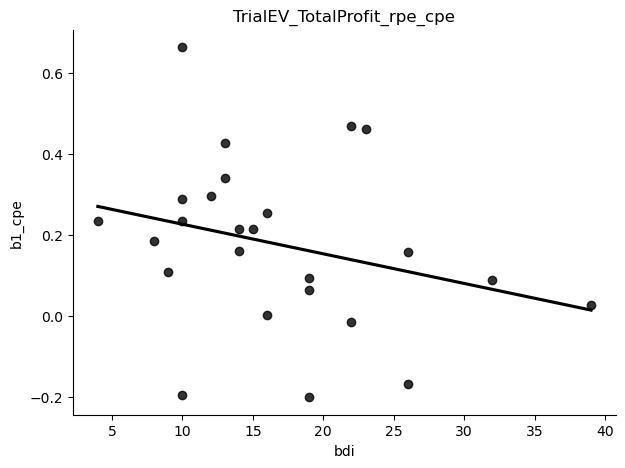

b1_cpe -0.003990048482313616 0.591741777073299
model TrialEV_TotalProfit_Profit_cpe bdi corr: -0.09727902024133903 0.6436559062433382


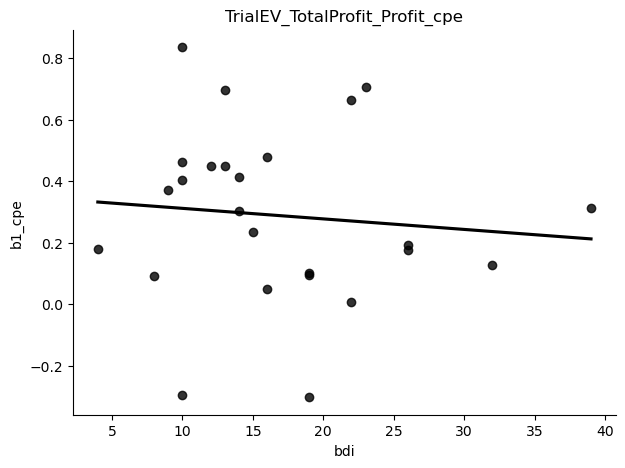

b1_cpe -0.031969705612264476 0.05800742404418526
model TrialEV_rpe_Profit_cpe bdi corr: -0.3690058734595548 0.0694861901485121


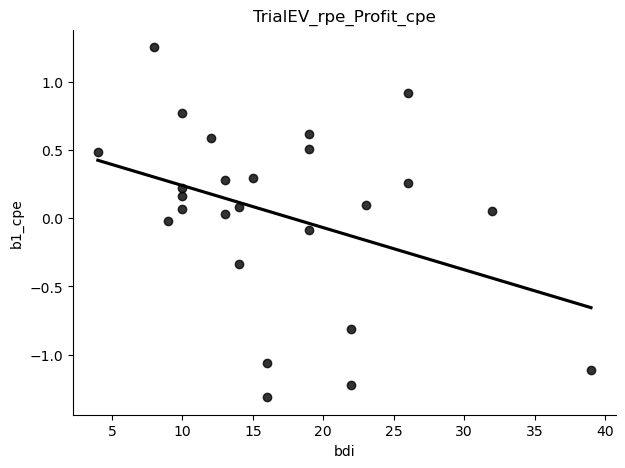

b1_cpe -0.008192999520544537 0.1716554831386794
model TotalProfit_rpe_Profit_cpe bdi corr: -0.3217645678443821 0.11676392164146045


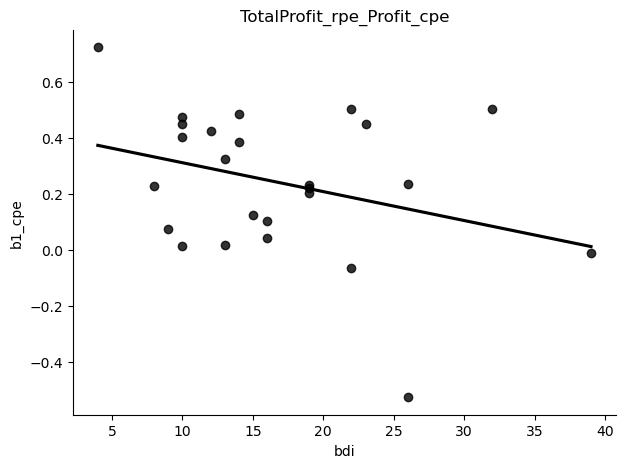

b1_cpe -0.002372392117158384 0.6666457096258903
model GambleEV_TotalProfit_rpe_Profit_cpe bdi corr: -0.021884431727781425 0.9173024691512299


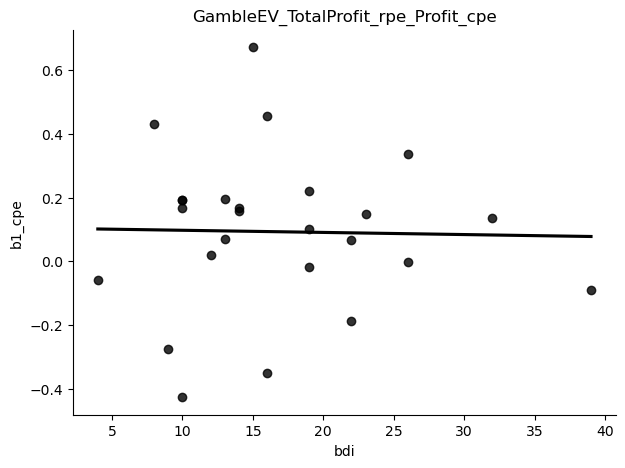

b1_cpe -0.0029461778089532775 0.5707951170642356
model TrialEV_TotalProfit_rpe_Profit_cpe bdi corr: -0.10582840309135687 0.6146341294395994


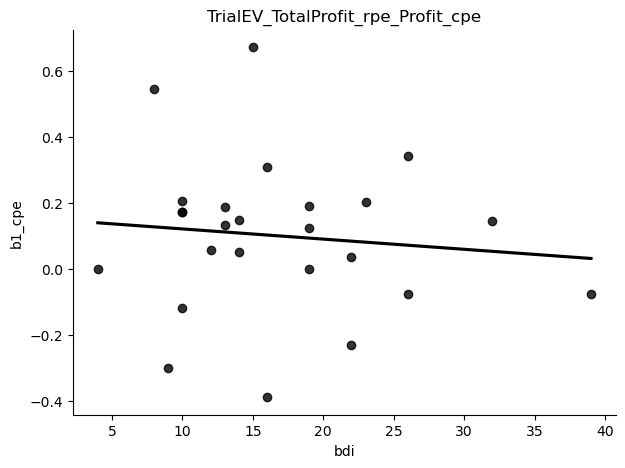

In [38]:
%matplotlib inline
sig_models = []
for model_id in list(all_models_output.keys()):
    target_var = model_id.split('_')[-1]
    target_id  = ('_').join(['b1',target_var])

    df = all_models_output[model_id]
    # df = df[~df.subj_id.isin(bad_subj)]
    
    model_rlm = sm.RLM(df[target_id].values,sm.add_constant(df.bdi.values), M=sm.robust.norms.HuberT()).fit()
    print(target_id,model_rlm.params[-1],model_rlm.pvalues[-1])
    if model_rlm.pvalues[-1] <0.05:
        sig_models.append(model_id)
    r,p = pearsonr(df.bdi,df[target_id])
    print(f'model {model_id} bdi corr:',r,p)
    # if p< 0.1:
    #     sig_models.append(model_id)
    fig,ax = plt.subplots(1,1,figsize=(7,5))
    # plt.scatter(x=df.bdi,y=df.b1_cpe)
    sns.regplot(data=df,x='bdi',y=target_id,scatter=True,color='k',ci=None)
    plt.title(f'{model_id}')
    sns.despine()
    plt.show()

In [47]:
final_model_id = 'GambleEV_rpe_cpe'

model_df = all_models_output[final_model_id]
model_df = model_df[~model_df.subj_id.isin(bad_subj)]



In [49]:
model_df


,subj_id,bdi,model_id,bic,negll,gamma,b0,b1_rpe,b1_GambleEV,b1_cpe
0,MS002,14,GambleEV_rpe_cpe,80.125593,30.282739,0.877024,3.440438e-03,0.299070,0.126652,0.140692
1,MS003,8,GambleEV_rpe_cpe,84.150274,32.295080,1.000000,-3.893452e-09,0.185238,0.123082,0.007634
2,MS009,16,GambleEV_rpe_cpe,90.978791,35.709338,0.000010,7.313793e-04,-0.049813,0.170419,-0.071811
3,MS011,13,GambleEV_rpe_cpe,85.338366,32.889125,0.674549,5.068646e-03,0.054650,0.369909,-0.093073
4,MS015,26,GambleEV_rpe_cpe,87.950095,34.194990,0.350223,1.219577e-02,-0.334477,-0.317128,0.479824
5,MS016,10,GambleEV_rpe_cpe,80.594192,30.517039,0.576958,-1.220904e-02,0.141524,0.220961,0.155244
6,MS017,26,GambleEV_rpe_cpe,69.415586,24.927736,0.679278,2.788644e-02,0.158727,0.142753,0.347091
7,MS019,12,GambleEV_rpe_cpe,84.566768,32.503327,0.319153,1.095672e-02,0.051342,0.155792,0.181217
8,MS022,10,GambleEV_rpe_cpe,83.324809,31.882347,0.816253,1.314985e-03,-0.082785,0.139380,0.149947
9,MS024,16,GambleEV_rpe_cpe,88.242295,34.341090,0.041394,-2.509526e-02,-0.032333,0.343499,0.112525


b0 -11.750142521979082 0.8756994917077385


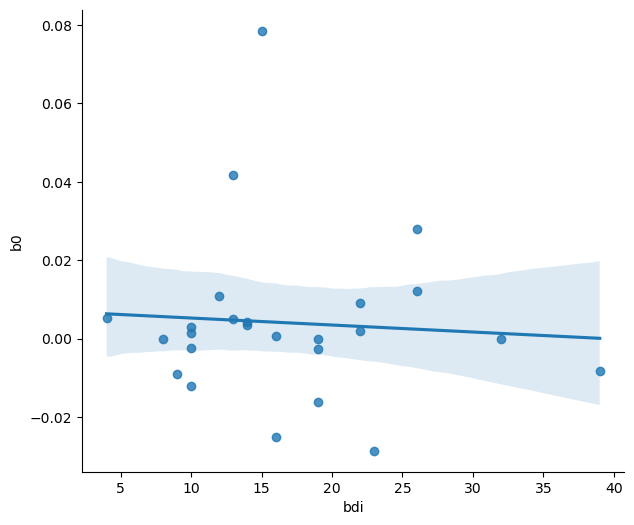

In [61]:
fig,ax = plt.subplots(figsize=(7,6))
sns.regplot(data=model_df,x='bdi',y='b0',scatter=True)
model_rlm = sm.RLM(model_df.bdi.values, sm.add_constant(model_df.b0), M=sm.robust.norms.HuberT()).fit()
print('b0',model_rlm.params.b0,model_rlm.pvalues.b0)

sns.despine()
plt.show()


b1_rpe -14.160533295391042 0.07799815426289236


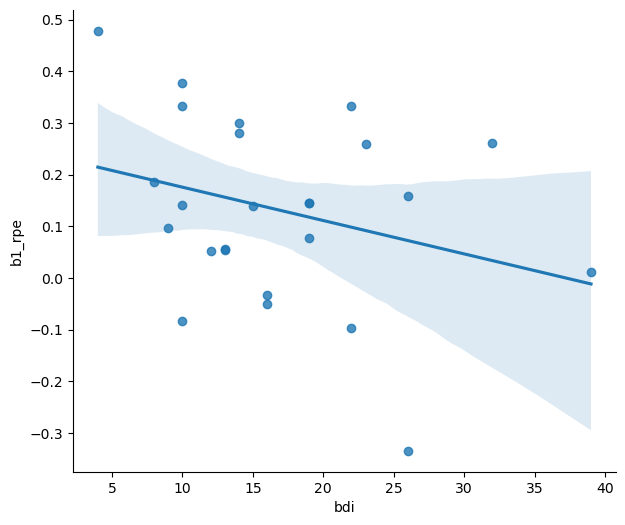

In [60]:
fig,ax = plt.subplots(figsize=(7,6))
sns.regplot(data=model_df,x='bdi',y='b1_rpe',scatter=True)
model_rlm = sm.RLM(model_df.bdi.values, sm.add_constant(model_df.b1_rpe), M=sm.robust.norms.HuberT()).fit()
print('b1_rpe',model_rlm.params.b1_rpe,model_rlm.pvalues.b1_rpe)

sns.despine()
plt.show()


b1_GambleEV -13.700573909151233 0.058448987598963206


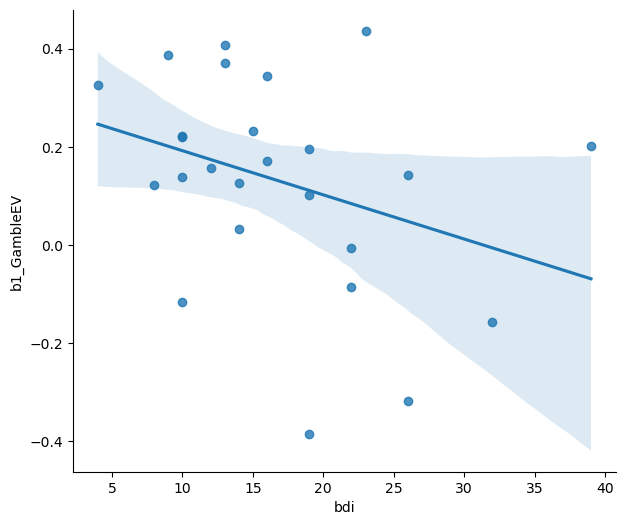

In [62]:
fig,ax = plt.subplots(figsize=(7,6))
sns.regplot(data=model_df,x='bdi',y='b1_GambleEV',scatter=True)

model_rlm = sm.RLM(model_df.bdi.values, sm.add_constant(model_df.b1_GambleEV), M=sm.robust.norms.HuberT()).fit()
print('b1_GambleEV',model_rlm.params.b1_GambleEV,model_rlm.pvalues.b1_GambleEV)

sns.despine()
plt.show()


b1_cpe 14.46346905301355 0.016210102836922393


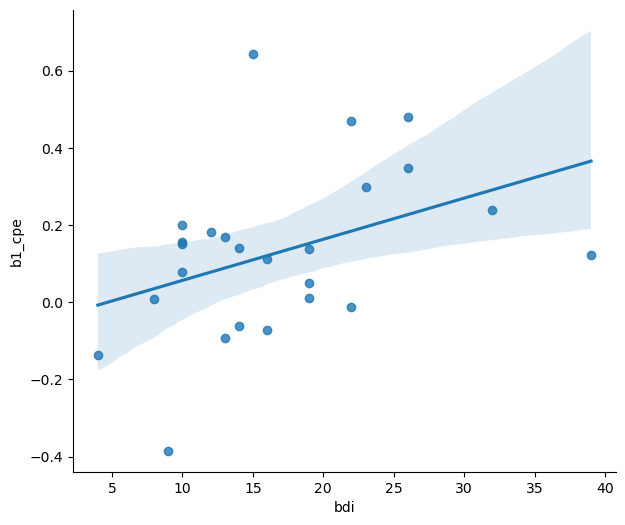

In [63]:
fig,ax = plt.subplots(figsize=(7,6))
sns.regplot(data=model_df,x='bdi',y='b1_cpe',scatter=True)

model_rlm = sm.RLM(model_df.bdi.values, sm.add_constant(model_df.b1_cpe), M=sm.robust.norms.HuberT()).fit()
print('b1_cpe',model_rlm.params.b1_cpe,model_rlm.pvalues.b1_cpe)

sns.despine()
plt.show()
